In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imodelsx import embgam
from datasets import load_dataset
from sklearn.base import ClassifierMixin, RegressorMixin
import pandas as pd
from preprocess import clean_headlines, sample_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import collections
import copy
import transformers
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from tqdm import tqdm



In [2]:
def predict(model, X, warn=True):
    """For regression returns continuous output.
    For classification, returns discrete output.
    """
    preds, frac_unseen_ngrams, unseen_ngrams_list = _predict_cached(model, X, warn=warn)
    return np.argmax(preds, axis=1), frac_unseen_ngrams, unseen_ngrams_list


def _predict_cached(model, X, warn):
    """Predict only the cached coefs in model.coefs_dict_"""
    assert hasattr(model, "coefs_dict_"), "coefs are not cached!"
    preds = []
    frac_unseen_ngrams = []
    unseen_ngrams_list = []
    for x in X:
        n_unseen_ngrams = 0
        pred = np.zeros(len(model.classes_))
        seqs = embgam.embed.generate_ngrams_list(
            x,
            ngrams=model.ngrams,
            tokenizer_ngrams=model.tokenizer_ngrams,
            all_ngrams=model.all_ngrams,
        )
        
        unseen_ngrams = []
        for seq in seqs:
            if seq in model.coefs_dict_:
                pred += model.coefs_dict_[seq]
            else:
                unseen_ngrams.append(seq)
                n_unseen_ngrams += 1

        unseen_ngrams_list.append(unseen_ngrams)
        preds.append(pred)
        frac_unseen_ngrams.append(n_unseen_ngrams / len(seqs))

    return np.array(preds), frac_unseen_ngrams, unseen_ngrams_list

def cache_linear_coefs(emb_model, X):
        """Cache linear coefs for ngrams into a dictionary model.coefs_dict_
        If it already exists, only add linear coefs for new ngrams
        """

        model = transformers.AutoModel.from_pretrained(
            emb_model.checkpoint).to(device)
        tokenizer_embeddings = transformers.AutoTokenizer.from_pretrained(
            emb_model.checkpoint)

        ngrams_list = emb_model._get_ngrams_list(X)

        # dont recompute ngrams we already know
        if hasattr(emb_model, 'coefs_dict_'):
            coefs_dict_old = emb_model.coefs_dict_
        else:
            coefs_dict_old = {}
        ngrams_list = [ngram for ngram in ngrams_list
                       if not ngram in coefs_dict_old]
        if len(ngrams_list) == 0:
            print('\tNothing to update!')
            return

        # compute embeddings
        """
        # Faster version that needs more memory
        tokens = tokenizer(ngrams_list, padding=args.padding,
                           truncation=True, return_tensors="pt")
        tokens = tokens.to(device)

        output = emb_model(**tokens) # this takes a while....
        embs = output['pooler_output'].cpu().detach().numpy()
        return embs
        """
        # Slower way to run things but won't run out of mem
        embs = []
        for i in tqdm(range(len(ngrams_list))):
            tokens = tokenizer_embeddings(
                [ngrams_list[i]], padding=True, truncation=True, return_tensors="pt")
            tokens = tokens.to(device)
            output = model(**tokens)
            emb = output[emb_model.layer].cpu().detach().numpy()
            if len(emb.shape) == 3:  # includes seq_len
                emb = emb.mean(axis=1)
            embs.append(emb)
        embs = np.array(embs).squeeze()
        if emb_model.normalize_embs:
            embs = emb_model.normalizer.transform(embs)

        # save coefs
        coef_embs = emb_model.linear.coef_.squeeze().transpose() 
        print(embs.shape)
        print(coef_embs.shape)
        linear_coef = embs @ coef_embs
        emb_model.coefs_dict_ = {
            **coefs_dict_old,
            **{ngrams_list[i]: linear_coef[i]
               for i in range(len(ngrams_list))}
        }
        print('coefs_dict_ len', len(emb_model.coefs_dict_))

In [3]:
# load data
with open(f"Data/huffpost.pkl", "rb") as f:
    huffpost_data = pkl.load(f)

huffpost_data = clean_headlines(huffpost_data)
test_data, test_labels = sample_data(huffpost_data, year=2014, in_dist=True, frac=1)

with open(f"models/expt3/expt3_ngrams_2_bert_uncased.pkl", "rb") as f:
    m = pkl.load(f)

m2 = copy.deepcopy(m)
cache_linear_coefs(m2, test_data[:3000]])
pkl.dump(m2, open(f"models/expt3/expt3_ngrams_2_bert_uncased_cached.pkl", "wb"))

# predict
for model in [m, m2]:
    preds, frac_unseen_ngrams, unseen_ngrams_list = predict(model, test_data)
    print("2014 OOD Test set accuracy: ", np.mean(preds == test_labels))
    print("Mean/Std Frac unseen ngrams: ", np.mean(frac_unseen_ngrams), "/", np.std(frac_unseen_ngrams))

/Users/aaskari/.pyenv/versions/3.9.7/envs/emb-gam/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 1.2.0 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificatio

IndexError: index 100 is out of bounds for axis 0 with size 100

In [28]:
idx_wrong_pred = [i for i, (p, l) in enumerate(zip(preds, test_labels)) if p != l]

unseen_ngrams_wrong_pred = []
data_wrong_pred = []
true_label = []
pred_label = []
label_to_category = {0: 'black_voices', 
    1: 'business', 2: 'comedy', 3: 'crime', 4: 'entertainment', 
    5: 'impact', 6: 'queer_voices', 7: 'science', 8: 'sports', 
    9: 'tech', 10: 'travel'
}
for i in idx_wrong_pred:
    unseen_ngrams_wrong_pred.append(unseen_ngrams_list[i])
    data_wrong_pred.append(test_data[i])
    true_label.append(label_to_category[test_labels[i]])
    pred_label.append(label_to_category[preds[i]])

df = pd.DataFrame([data_wrong_pred, unseen_ngrams_wrong_pred, true_label, pred_label]).T
df.columns = ["headline","unseen_ngrams", "true_label", "pred_label"]
df["num_unseen"] = df.unseen_ngrams.apply(lambda x: len(x))



In [30]:
df.sort_values(by="num_unseen", ascending=False)

,headline,unseen_ngrams,true_label,pred_label,num_unseen
183,from fillmore east to the moon: chats with abb...,"[fillmore, chats, abb, jaimoe, cpd, potm, shea...",entertainment,comedy,33
2589,"rockabilly, empty hearts & psycho sisters: cha...","[rockabilly, chats, setzer, vicki, cowsill, ro...",entertainment,comedy,27
3713,"'how do we treat the little people, joan?' i a...","[we treat, treat the, , joan, joan?, ' i, i as...",entertainment,comedy,25
5156,"the manhattan transfer's tim hauser passes, pl...","[hauser, chats, numan, bergin, colton, rhett, ...",entertainment,travel,24
1980,from bulldogs to elephant walks: chats with jo...,"[chats, mathis, mancini, anson, rmh, from bull...",entertainment,comedy,24
...,...,...,...,...,...
3283,the best christmas movies,[],entertainment,comedy,0
1205,"thank you, tim cook",[],queer_voices,sports,0
1225,the 7-letter word,[],comedy,queer_voices,0
5495,bankrupt,[],business,travel,0


In [55]:
binned_data = {}
binned_labels = {}
for i, x in enumerate(test_data):
    num_unseen = len(unseen_ngrams_list[i])
    key = num_unseen
    if key not in binned_data.keys():
        binned_data[key] = [x]
        binned_labels[key] = [test_labels[i] == preds[i]]
    else:
        binned_data[key].append(x)
        binned_labels[key].append(test_labels[i] == preds[i])

binned_data = collections.OrderedDict(sorted(binned_data.items()))
binned_labels = collections.OrderedDict(sorted(binned_labels.items()))


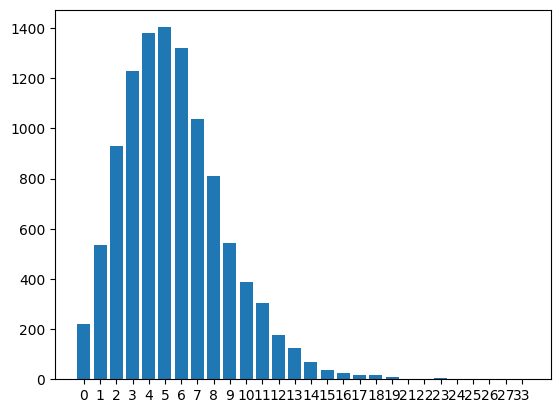

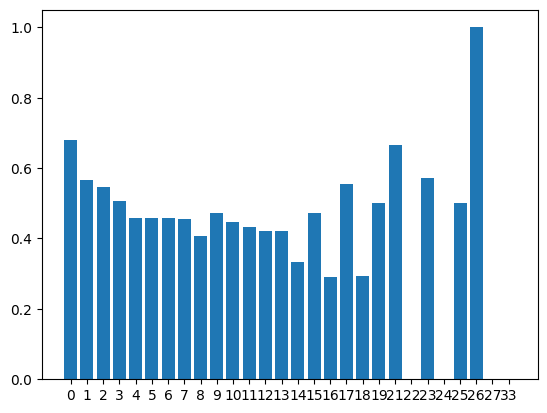

In [60]:
# Plot number of test points against number of unseen ngrams at test time
bin_labels = binned_data.keys()
bin_values = [len(v) for v in binned_data.values()]

x = range(len(bin_labels))
plt.bar(x, height=bin_values)
plt.xticks(x, bin_labels)
plt.show()


# Plot classifaction accuracy against number of unseen ngrams
x = range(len(bin_labels))
plt.bar(x, height=[sum(y)/len(y) for _, y in binned_labels.items()])
plt.xticks(x, bin_labels)

# Show the plot
plt.show()